# SMARTGRAM
<h1 class="mb-0 text-primary">A tool for fashion influencers.</h1>

In [1]:
from IPython.display import Video
Video("test.mp4",width=1024, height=576)

In the last years, influencer marketing has become a strategy for brands. Brands partner with prominent social media influencers to create sponsored content that resonates with a brand’s target audience. But brands are only interested in working with influences who have active and responsive audiences: the higher your engagement metrics, the better chances of getting a business to sponsor you.

For Instagram, the main engagement metrics are likes and comments; they show how interested are the followers in the influencer content. So I thought it would be good to have a tool that predicts these metrics based on the Instagram post content.

My goal is to use a regression model to predict and understand how Instagram data in a post affect likes and comments. The data includes followers, following, media count (number of posts in the feed), caption, kind of the picture (selfie, outdoor, body snap, editorial image), content on the photo (smiles, faces, products, logos).

With these models and the insights obtained, I built SMARTGRAM using Streamlit. You can see the demo above or try it by yourself <a href="">here</a> and the code is <a href="2">here</a>.

My analysis consist of the next sections:
- <a href="#data">Data description and outliers treatment</a>
- <a href="#numerical">Numerical data treatment</a>
- <a href="#text">Text cleaning</a>
- <a href="#models">Models</a>
- <a href="#insight">Insights</a>


<h2 class=" lead mb-3 text-primary" id="data"> The data </h2>

I obtained the data from the project https://arxiv.org/abs/1704.04137. In their data project they obtained 24,752 Instagram posts by 13,350 people on Instagram through the Instagram’s API. The data collection was done over a month period in January 2015. And in all the posts renowned fashion brands are named in the hashtags.

The data includes:
- Basic information of the instagram account posting:
  Encrypted user id, amount of followers, amount of accounts following.
- Information about the post:
  Creation time of the post, engagement metrics (likes, comments), brand mentioned, captions, hashtags used.
- Learned features from their model (identifies the kind of picture). 
- Learned features from Microsoft emotion API (identifies the emotion of the people that appears in the picture)


<h3 class=" lead mb-3 text-primary"> First step: installing all the packages and getting the data</h3>

I'm using python for this project.The nltk (the natural language toolkit) is a package of tools for working with text data. And scikit-learn for the machine learning models.

I donwloaded the data in a pandas dataframe, I will be working with the hashtags and captions but I'm keeping the columns of followers, likes and comments because I want to compare the different engagement metrics for the brand, brandcategories and clusters.

My first step was a simple formating (removing non-alphabetical characters and lowercasing) in the name of the columns and in the columns that includes the brandnames.


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
from sklearn.neighbors import LocalOutlierFactor
import re
import nltk
from nltk.corpus import stopwords
import en_core_web_sm
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
import joblib
from joblib import dump
import warnings
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, make_scorer,mean_squared_error
from math import sqrt

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


#print('Loading words, spacy, punktd, stopwords')
nltk.download('words')
nlp = en_core_web_sm.load()
words = set(nltk.corpus.words.words())
nltk.download('stopwords')
#nltk.download('punkt')
print('done, now loading text and basic formating of columns name')


# Read dataset and format texts 
df = pd.read_csv(r'fashion data on instagram.csv', index_col=0)#.sample(frac=0.25)
df = df.loc[~df.index.duplicated(keep='first')]
df = df[~df['Caption'].isnull()]
#Formating column names, brand categories names and brand names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('?', '')
df.brandname = df.brandname.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('?', '')
df.brandcategory = df.brandcategory.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('?', '')


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\thalia\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


done, now loading text and basic formating of columns name


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thalia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Outliers

<h4 class=" text-primary" > In Instagram is very common to use bots to inflate the followers quantity. Accounts using bots are easy to detect because their engagement metrics per follower are low. These accounts with fake followers can hurt my predictions, I decided to remove them using an outlier detector. </h4>

The local outlier detector identify outliers by finding samples with a lower density of neighbors. The density is calculated by measuring the distance of its k-nearest neighbors.t measures the local deviation of density of a given sample with respect to its neighbors. The variables that I decided to use to identify outliers are likes, comments, followings and followers. This is because apart from having low amount of likes and comments, accounts with fake followers have large number of followers, or some times just follow other accounts to gain followers.

In [3]:
def filterbyoutlier(df,vector):
    clfhash = LocalOutlierFactor(n_neighbors=50)
    clfhash.fit_predict(vector)
    df['outlier_factor_hash'] = clfhash.negative_outlier_factor_
    return df[df['outlier_factor_hash']>-5]
print(df.shape)
ndf = filterbyoutlier(df,df[['likes','comments','followings', 'followers']])
print(ndf.shape)

(24037, 32)
(23393, 33)


In [4]:
targets = ndf[['likes','comments']].copy(deep=True)
text_df = ndf[['caption']].copy(deep=True)
numerical = ndf[['followings', 'followers','mediacount','selfie','bodysnap','marketing','productonly','nonfashion','face','logo','brandlogo','smile','outdoor','numberofpeople','numberoffashionproduct']].copy(deep=True).round(0)


<h2 class=" lead mb-3 text-primary" id="numerical"> Numerical data </h2>

In the data set they included in their results learned variables of emotions. <h4 class=" lead mb-3 text-primary" >  For this project I'm not working with these learned features from the data set. I wanted to make this useful as posible so I'm including variables that are easily obtained from instagram or anybody can quantitative measure from the pictures.</h4>

- The numerical variables used are: followings, followers, mediacount.
- If the pictures is a: selfie', 'bodysnap', 'marketing' (editorial or professional picture), 'productonly', 'nonfashion', 'outdoor'
- If the pictures include: 'faces','logos','brandlogos','smiles','number of people','number of fashion products'.

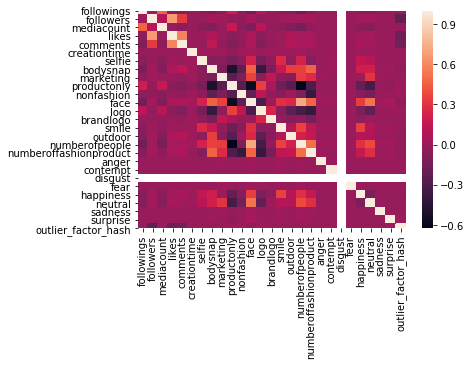

In [5]:
corrmat = ndf.round(0).corr()
sns.heatmap(corrmat, xticklabels=corrmat.columns, yticklabels=corrmat.columns)

In [6]:
numerical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23393 entries, 1171579752855683619_212070047 to 1171565778125281443_253427645
Data columns (total 15 columns):
followings                23393 non-null float64
followers                 23393 non-null float64
mediacount                23393 non-null int64
selfie                    23393 non-null float64
bodysnap                  23393 non-null float64
marketing                 23393 non-null float64
productonly               23393 non-null float64
nonfashion                23393 non-null float64
face                      23393 non-null float64
logo                      23393 non-null float64
brandlogo                 23393 non-null float64
smile                     23393 non-null float64
outdoor                   23393 non-null float64
numberofpeople            23393 non-null float64
numberoffashionproduct    23393 non-null float64
dtypes: float64(14), int64(1)
memory usage: 2.9+ MB


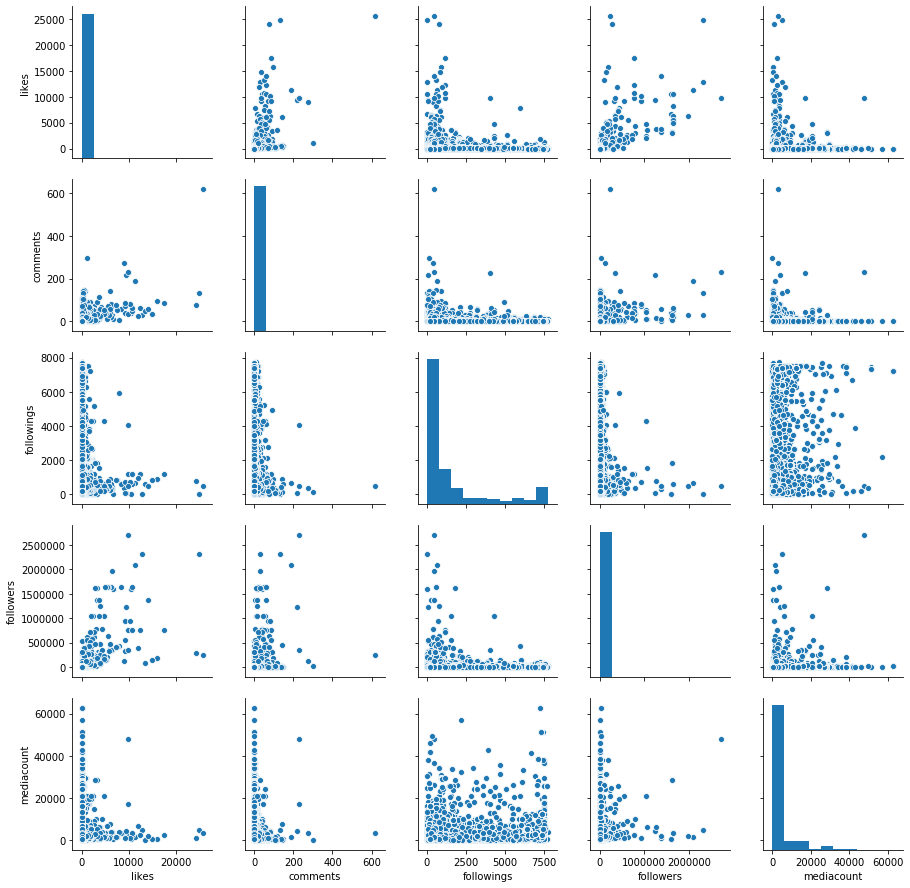

In [7]:
sns.pairplot(ndf[['likes','comments','followings','followers','mediacount']])

In [8]:
ndf[['likes','comments','followings','followers','mediacount']].describe()

,likes,comments,followings,followers,mediacount
count,23393.000000,23393.000000,23393.000000,2.339300e+04,23393.000000
mean,95.436626,2.742273,1541.602032,1.074766e+04,3309.798529
std,535.764146,9.047260,2175.293220,6.233162e+04,6287.077069
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,10.000000,0.000000,224.000000,4.070000e+02,307.000000
50%,23.000000,1.000000,550.000000,1.451000e+03,846.000000
75%,55.000000,2.000000,1658.000000,6.475000e+03,2791.000000
max,25528.000000,619.000000,7741.000000,2.706069e+06,62850.000000


<h2 class=" lead mb-3 text-primary" id="text">Text cleaning  </h2>

I'm taking the captions and creating a text vector that I will later use with my numerical data for my model predictions.
First step is the text processing for captions including hashtags. The cleaning fuction takes all the entries in a column, removes the non-alphabetical characters, stopwords and encrypted words and returns the remaining text in lower cases.

Then from the cleaned text I will create the text vectors with the tfidvectorizer. Tokenize is called inside of vectorizer, it takes the text entries, extracts the words and reduce them to their roots.<h4 class=" lead mb-3 text-primary" > I'm exporting the cleaning function and vectorizer because it will be needed to process captions in real time for the app </h4>

I got 188 words for the vectors, I'm creating a data frame to save the vector for each caption and I later will concat it with the numerical variables for the predictors dataframe.

In [9]:
def cleaning(frame,col):
    """ 
    Function to clean text from a column in a data frame 
  
    This funtion removes non alphabethic characters,stop words and numerical characters and return text in lowers. 
  
    Parameters: 
    Data frame, text column 
  
    Returns: 
    values clean text from column
  
    """
    newframe=frame.copy()   
    punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}','#',"%"]
    stop_words = text.ENGLISH_STOP_WORDS.union(punc)
    stop_words = list(stop_words)  
    newframe[col]=newframe[col].str.replace('\d+', '').str.replace('\W', ' ').str.lower().str.replace(r'\b(\w{1,3})\b', '')
    newframe[col] = [' '.join([w for w in x.lower().split() if w not in stop_words]) for x in newframe[col].tolist()] 
    newframe['Cleantext'] =[' '.join(word for word in x.split() if not word.startswith('uf')if not word.startswith('ue')if not word.startswith('u0')) for x in newframe[col].tolist()] 
 
    content = newframe['Cleantext']#.values
    return content

stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text)]


In [10]:
vectorizing = TfidfVectorizer(sublinear_tf=True,  min_df=300, norm='l2', 
                              ngram_range=(1, 1), tokenizer = tokenize)
clean_captions = cleaning(text_df,'caption')
%time clean_captions_vector = vectorizing.fit_transform(clean_captions.values)

Wall time: 19.1 s


In [11]:
names= vectorizing.get_feature_names()
textdf = pd.DataFrame(columns=["{}{}".format('txt_',i) for i in names])
joblib.dump(textdf, 'textdf.pkl')
text = pd.DataFrame(clean_captions_vector.toarray(), columns=["{}{}".format('txt_',i) for i in names])
text.head()

,txt_accessori,txt_acnestudio,txt_adida,txt_alexandermcqueen,txt_alexanderwang,txt_americanapparel,txt_americaneagl,txt_apparel,txt_armani,txt_authent,...,txt_wear,txt_weloveshop,txt_what,txt_whatsapp,txt_white,txt_winter,txt_women,txt_work,txt_zara,txt_zegna
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h2 class=" lead mb-3 text-primary" id="Models"> Building the models </h2>

In [12]:
X =  pd.concat([numerical,text.set_index(numerical.index)], axis=1, sort=False)
Y = targets['likes'] 
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
scoring_evals = {'MSE': make_scorer(mean_squared_error)}
param_test = { 'alpha':[0.5, 0.1, 0.01, 0.001, 0.0001]}

gsearch = GridSearchCV(estimator = Ridge(), param_grid = param_test, scoring=scoring_evals, refit='MSE', n_jobs=4, iid=False, cv=5)
gsearch.fit(X_train,y_train)
#print(gsearch.cv_results_)
print(gsearch.best_params_ )


(23393, 203)
{'alpha': 0.0001}


In [13]:
likesmodel=Ridge(alpha=0.0001)
likesmodel.fit(X_train,y_train)
pred_test_rr = likesmodel.predict(X_test)
pred_test_rr = pred_test_rr.clip(min=0)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

303.51583956831524
0.4576326399859941


In [14]:
Y1 = targets['comments'] 
X_train, X_test, y1_train, y1_test = train_test_split(X, Y1, test_size=0.3, random_state=42)
scoring_evals = {'MSE': make_scorer(mean_squared_error)}
param_test = { 'alpha':[0.5, 0.1, 0.01, 0.001, 0.0001]}

gsearch = GridSearchCV(estimator = Ridge(), param_grid = param_test, scoring=scoring_evals, refit='MSE', n_jobs=4, iid=False, cv=5)
gsearch.fit(X_train,y1_train)
#print(gsearch.cv_results_)
print(gsearch.best_params_ )


{'alpha': 0.0001}


In [15]:
commentmodel=Ridge(alpha=0.0001)
commentmodel.fit(X_train,y1_train)
pred_test_rr = commentmodel.predict(X_test)
pred_test_rr = pred_test_rr.clip(min=0)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y1_test, pred_test_rr))

419.2925926850647
0.09617584239950316


Saving the models for the app

In [16]:
joblib.dump(vectorizing, 'vectorizer.pkl')
joblib.dump(likesmodel, 'likesmodel.pkl')
joblib.dump(commentmodel, 'commentmodel.pkl')

['commentmodel.pkl']

<h2 class=" lead mb-3 text-primary" id="insights"> Model insights </h2>

In [17]:
featureslist = X.columns.tolist()
importance = commentmodel.coef_
comments_features = {featureslist[i]: importance[i] for i in range(len(importance))} 
sorted_comments_features = sorted(comments_features, key=comments_features.get, reverse=True)
print(sorted_comments_features[0:20])

['txt_chanelboy', 'txt_daili', 'txt_rolex', 'txt_kelli', 'txt_just', 'txt_mensstyl', 'txt_instafashion', 'txt_nworldwid', 'txt_boot', 'txt_uniqlo', 'txt_black', 'txt_wear', 'txt_great', 'txt_ootd', 'txt_picoftheday', 'txt_girl', 'txt_look', 'txt_celin', 'txt_lynaround', 'txt_jacket']


In [18]:
notext =  [feature for feature in sorted_comments_features if not 'txt'in feature]
for key in notext:
    print(key, comments_features[key])

bodysnap 1.263419260138869
outdoor 0.5967379582446
numberoffashionproduct 0.022044412872583793
followers 5.296383952574316e-05
mediacount -6.769046387658883e-05
followings -0.00013393038345958498
face -0.03286417318919733
brandlogo -0.07122486730320512
logo -0.07309320693012322
numberofpeople -0.07924011547099206
selfie -0.08046298379604759
productonly -0.3142427177903763
nonfashion -0.3315103802298467
marketing -0.41636023570645364
smile -0.8265956407934824


In [19]:
importance = likesmodel.coef_
likes_features = {featureslist[i]: importance[i] for i in range(len(importance))} 
sorted_likes_features= sorted(likes_features, key=likes_features.get, reverse=True)
print(sorted_likes_features[0:20])

['txt_madeinitali', 'txt_brunellocucinelli', 'txt_nworldwid', 'txt_wear', 'txt_rolex', 'txt_lynaround', 'txt_pucci', 'txt_just', 'txt_pari', 'txt_daili', 'txt_work', 'txt_adida', 'txt_mensstyl', 'txt_girl', 'txt_personalshop', 'txt_women', 'txt_bespok', 'txt_link', 'txt_weloveshop', 'txt_ootd']


In [20]:
notext =  [feature for feature in sorted_likes_features if not 'txt'in feature]
for key in notext:
    print(key, likes_features[key])

selfie 52.75073307123706
outdoor 50.93714749477349
face 31.94156085768941
bodysnap 9.731457231659746
followers 0.005991618882559007
followings -0.0028015188403658115
mediacount -0.006342177991830079
numberoffashionproduct -1.2131530109781952
brandlogo -4.741921618705271
nonfashion -6.719203880428539
logo -7.049031870697593
numberofpeople -16.706489003638723
marketing -24.48737072251009
productonly -26.4926318505968
smile -42.05961848223549
